In [ ]:
# !pip install catboost
# !pip install optuna

# Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import gc

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

from scipy import stats
from tqdm import tqdm_notebook
from typing import Tuple, List

from catboost import CatBoostClassifier
from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

from google.colab import drive
drive.mount('/content/drive')

RAND = 25
N_FOLDS = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка данных

In [ ]:
train_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/train_data_prep.ftr')
train_df.head()

,customer_ID,D_63_count,D_63_last,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_68_count,D_68_last,D_68_nunique,...,D_131_diff,D_133_diff,R_28_diff,D_139_diff,D_140_diff,D_141_diff,D_143_diff,D_144_diff,D_145_diff,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,2,1,13,2,1,13,6,1,...,0.325439,50.031250,-0.648438,3.597656,1.142578,0.979004,4.289062,-0.532227,1.029297,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,1,1,13,2,1,13,6,1,...,0.117126,-0.687500,-0.718750,-0.552246,0.616699,0.632812,-0.603027,0.253418,1.375000,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,1,1,13,3,1,13,6,1,...,5.792969,3.992188,0.507812,-0.089844,-0.306152,-0.709961,-0.539551,-0.886230,-0.385254,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,1,1,13,2,1,13,3,3,...,-0.455078,0.545410,8.109375,-0.709473,-0.107361,0.314209,-0.170776,0.153564,-0.564453,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,1,1,13,2,1,13,6,1,...,0.481689,0.914551,0.534668,0.533691,0.409668,-0.208130,0.638184,0.097717,-0.560547,0


# Обучение

## Метрики

In [ ]:
def get_metrics(y_test: np.array, y_pred: np.array, y_score: np.array,
                name: str) -> pd.DataFrame:
    '''
    Возвращает датафрейм с метриками для предсказанных значений моделью.
    Используемые метрики: Accuracy, ROC_AUC, Precision, F1, Logloss, AMEX.

    Параметры:
        y_test (np.array): действительное значение класса
        y_pred (np.array): предсказание класса
        y_score (np.array): предсказание вероятности класса
    Возвращаемое значение:
        df_metrics (pd.DataFrame): датафрейм с метриками
    '''

    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    df_metrics['ROC_AUC'] = [roc_auc_score(y_test, y_score)]
    df_metrics['Precision'] = [precision_score(y_test, y_pred)]
    df_metrics['Recall'] = [recall_score(y_test, y_pred)]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    df_metrics['Logloss'] = [log_loss(y_test, y_score)]
    df_metrics['AMEX'] = amex_metric(y_test, y_score)
    
    return df_metrics

In [ ]:
def amex_metric(y_true: np.array, y_pred: np.array) -> float:
    '''
    Метрика AMEX расчитывается для действительного значения класса и 
    предсказанной вероятности класса .

    Параметры:
        y_true (np.array): действительное значение класса
        y_pred (np.array): предсказание вероятности класса
    Возвращаемое значение:
        result (float): значение метрики amex
    '''

    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])
    gini = [0, 0]
    
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    
    result = 0.5 * (gini[1] / gini[0] + top_four)
    return result


class Amex_metric_cat:
    '''Amex метрика для CatBoost'''
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):

        return amex_metric(target, approxes[0]), 0

    def get_final_error(self, error, weight):
        return error

## Тренировочные и тестовые данные

In [ ]:
X = train_df.drop(['customer_ID', 'target'], axis=1)
y = train_df['target']

# Категориальные столбцы
cat_features = train_df.select_dtypes(include=['category']).columns.to_list()

# Подготовка данных для бинаризованного датафрейма
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_features), remainder='passthrough')
transformed = transformer.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RAND)

## Catboost + Optuna

Поиск оптимальных гиперпараметров с помощью Optuna

In [ ]:
def objective(
    trial,
    data_x: pd.DataFrame,
    data_y: pd.Series,
    cat_features: list,
    n_folds: int = 5,
    random_state: int = 25
) -> np.array:

    """
    Целевая функция для поиска параметров
    :param trial: кол-во trials
    :param data_x: данные объект-признаки
    :param data_y: данные с целевой переменной
    :param cat_features: список категориальных данных
    :param n_folds: кол-во фолдов
    :param random_state: random_state
    :return: среднее значение метрики по фолдам
    """
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        'n_estimators': trial.suggest_categorical("n_estimators", [1000]),
        # 'max_bin': trial.suggest_int('max_bin', 200, 400),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        # 'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': random_state,
        'loss_function': 'Logloss',
        'eval_metric': Amex_metric_cat(),
        # 'task_type': 'GPU',
        # 'bootstrap_type': 'Poisson',
        'cat_features': cat_features
    }

    cv_folds = StratifiedKFold(
        n_splits=n_folds, shuffle=True, random_state=random_state
    )
    cv_predicts = np.empty(n_folds)

    for idx, (train_idx, test_idx) in enumerate(cv_folds.split(data_x, data_y)):
        x_train, x_test = data_x.iloc[train_idx], data_x.iloc[test_idx]
        y_train, y_test = data_y.iloc[train_idx], data_y.iloc[test_idx]

        model = CatBoostClassifier(**param_grid, silent=True)
        model.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            early_stopping_rounds=100,
            verbose=False
        )
        predict = model.predict_proba(x_test)[:, 1]
        cv_predicts[idx] = amex_metric(y_test, predict)
    return np.mean(cv_predicts)

In [ ]:
study = optuna.create_study(direction="maximize", study_name="CatBoost")

function = lambda trial: objective(
    trial, X_train, y_train, cat_features, 5, 25)

study.optimize(function, n_trials=3, show_progress_bar=True)


In [ ]:
plot_param_importances(study)

In [ ]:
plot_optimization_history(study)

## Catboost

Обучение модели Catboost на лучших параметрах

In [ ]:
model = CatBoostClassifier(
    **study.best_params,
    random_state=RAND,
    eval_metric=Amex_metric_cat(),
    cat_features=cat_features
    )

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
    early_stopping_rounds=100
    )

# Вычисление предсказаний
preds_test = model.predict(X_test)
preds_prob_test = model.predict_proba(X_test)[:, 1]
preds_train = model.predict(X_train)
preds_prob_train = model.predict_proba(X_train)[:, 1]

/usr/local/lib/python3.7/dist-packages/catboost/core.py:1759: UserWarning:

Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'amex_metric': Cannot determine Numba type of <class 'function'>

File "<ipython-input-6-15cea6fb3b3b>", line 41:
    def evaluate(self, approxes, target, weight):
        <source elided>

        return amex_metric(target, approxes[0]), 0
        ^




In [ ]:
metric_df = get_metrics(y_test, preds_test, preds_prob_test, 'Catboost')
metric_df

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Catboost,0.895833,0.954934,0.808843,0.789841,0.799229,0.237188,0.772702


### Важность признаков

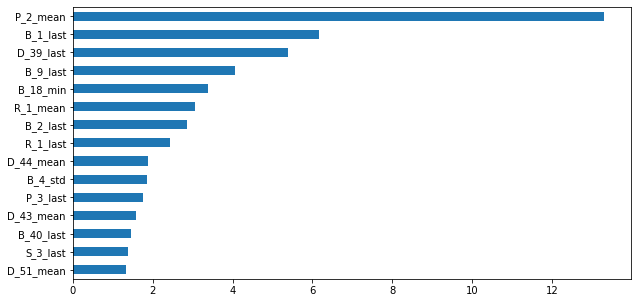

In [ ]:
feature_imp_cat = pd.Series(model.feature_importances_, index=X.columns)
feature_imp_cat.nlargest(15).sort_values(ascending=True).plot(kind='barh',
                                                              figsize=(10, 5));

# Предсказания

In [ ]:
# Загрузка тестовых данных(данные для предсказания)
test_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/test_data_prep.ftr')
print('Количество уникальных ID:', test_df['customer_ID'].unique().shape[0])

Количество уникальных ID: 406811


In [ ]:
# Уникальные ID клиентов и их количество
uniq_ID = test_df['customer_ID'].unique()
uniq_len = uniq_ID.shape[0]

# Разделяю одну воборку на несколько маленьких
step = uniq_len // 20
# Датафрейм для предсказанных значений
submis = pd.DataFrame({'customer_ID': pd.Series(dtype='object'),
                   'prediction': pd.Series(dtype='int64')})

for i in tqdm_notebook(range(0, uniq_len, step)):
    part_test_df = test_df[test_df['customer_ID'].isin(uniq_ID[i: i+step])]

#   Предсказание новых данных
    customer_ID = part_test_df['customer_ID']
    X_test = part_test_df.drop(['customer_ID'], axis=1)
    
    predict_ls = model.predict(X_test)

    preds = pd.DataFrame({'customer_ID': pd.Series(customer_ID), 
                        'prediction': pd.Series(predict_ls)})
    submis = pd.concat([submis, preds], axis=0, ignore_index=True)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
submis.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.0


In [ ]:
# Сохранение предсказаний

submis.to_csv('submission.csv', index=False)